# Exercise 3: Building chromatic model for the YSO HD 179218

With the advent of routine spectro-interferometry, the use of simple achromatic models to reproduce
interferometric observations often appears insufficient. 

**oimodeler** provides different tools to build chromatic models. 

### One method is to use parameter interpolators. 

As we will see, such feature can be very useful when modelling highly chromatic objects.

To illustrate the concept, let us consider the case of L-band MATISSE data obtained on the Herbig star HD179218. Our dataset consists of two MATISSE L-band observations:
- one observed with th UTs:  **OiXP_HD_179218_MATISSE_U1-U2-U3-U4_2021-05-28.fits**
- one observed with the ATs SMALL configuration : **OiXP_HD179218_MATISSE_A0-B2-C1-D0_2019-03-24.fits**

**Download the data from the cloud** 

### Let's first import some useful libraries including oiomdeler

In [1]:
import oimodeler as oim
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np

### We set the path to the fits files and load them into an oimData object

In [2]:
dir0=Path("C:\\Travail\\Cours et TP\\VLTI2024\\OIDATA\\data\\oifits\\HD179218")
filenames=list(dir0.glob("*.fits"))
data=oim.oimData(filenames)

### Plotting the absolute visibility (VISAMP) as a function of spatial frequency

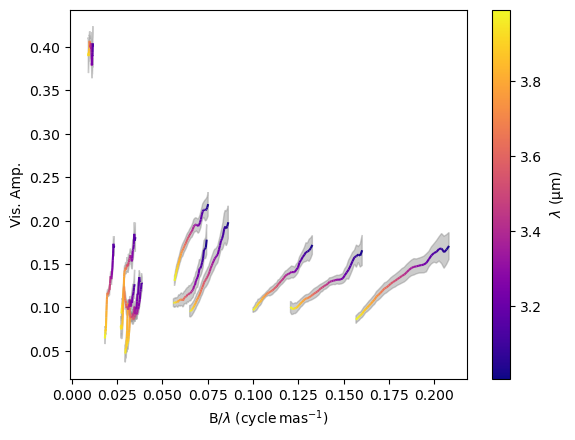

In [3]:
fig = plt.figure()
ax = plt.subplot(projection='oimAxes')
ax.oiplot(data, "SPAFREQ", "VISAMP", xunit="cycle/mas", label="Data",
                cname="EFF_WAVE",cunit="micron", errorbar=True)

### **Question : What is the origin of the chromatic slope on the visibilities at high spatial frequencies?**

### Let us try to model those data with a simple achromatic model 

Our model is composed of a point source for the unresolved star and a Gaussian distribution representing the circumstellar emission

In [4]:
g = oim.oimGauss()
pt = oim.oimPt()
m1 = oim.oimModel(g, pt)

### We define our parameters space

In [5]:
pt.params["f"] = oim.oimParamNorm(g.params["f"])
g.params["fwhm"].set( max = 100 )

### Creating and running a mcmc-fitter (fitting only the VISAMP) 

In [6]:
fit=oim.oimFitterEmcee(data, m1,nwalkers=10,dataTypes=["VISAMP"])
fit.prepare()
fit.run(nsteps=1000,progress=True)

100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 109.62it/s]


{'nsteps': 1000, 'progress': True}

### Printing and plotting the results

c1_GD_f = 0.88489 ± 0.00027 
c1_GD_fwhm = 57.60287 ± 0.16356 mas
chi2r = 20.18620


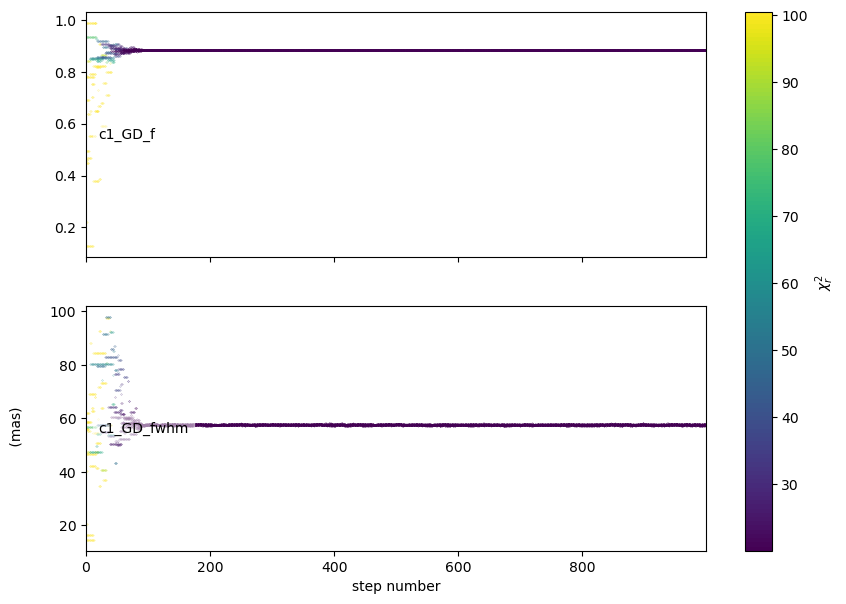

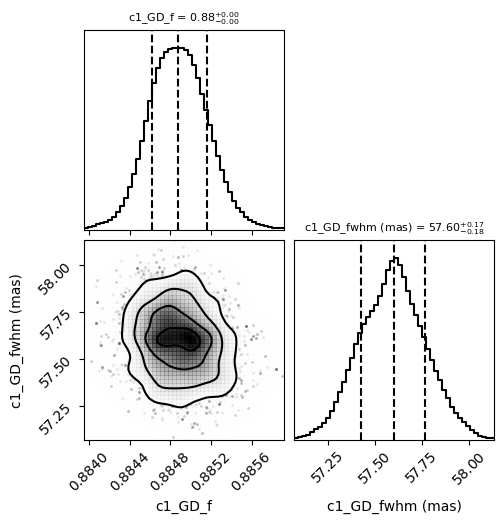

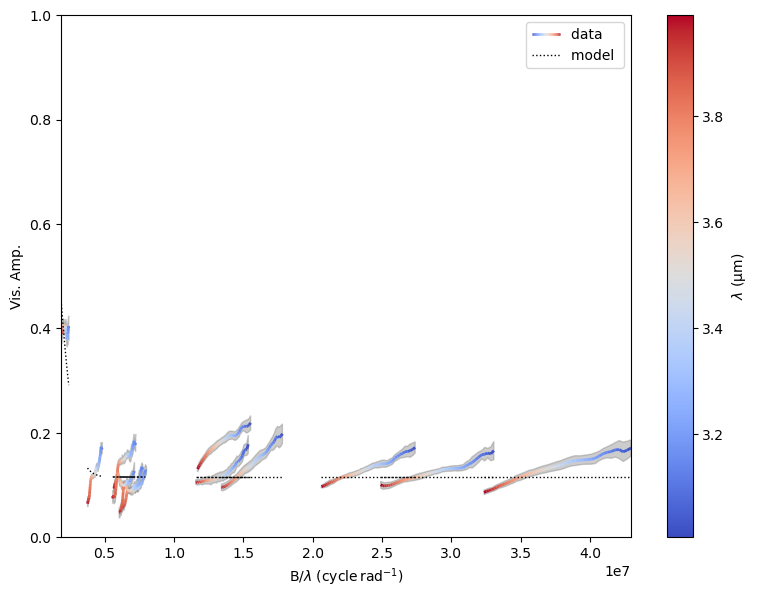

In [7]:
fit.printResults(mode='best', discard=500)
figWalker,axWalker = fit.walkersPlot(chi2limfact=5)
figCorner,axCorner = fit.cornerPlot(discard=500,chi2limfact=5)
figSim,axSim = fit.simulator.plot(["VISAMP"])

### **Question : In the best-fit model, could the chromatic slope of the visibilities be reproduced? If not, why?**

## Use of interpolators

Interpolators are objects that replace the single value of a parameter by a chromatic and/or time-dependent law that generates a new series of values for that parameter. They can be created using the
oimInterp method, which specifies the kind of interpolator. 

For more details and a list of interpolators, check the [oimodeler help on interpolators](https://oimodeler.readthedocs.io/en/latest/advancedExamples.html#parameters-interpolators)

for instance, the following script creates a Gaussian distribution with:
- a 1 mas fwhm between 3 and 3.5μm and
- a linearly increasing fwhm (from 1 mas to 2 mas) between 3.5 and 4 μm:

In [8]:
g = oim.oimGauss(fwhm=oim.oimInterp("wl", wl=[3e-6, 3.5e-6, 4e-6], values=[1, 1, 2]))
mg =  oim.oimModel(g)
# ### Let’s plot the chromatic images of such model for 5 values between 3 and 4 $\mu$m

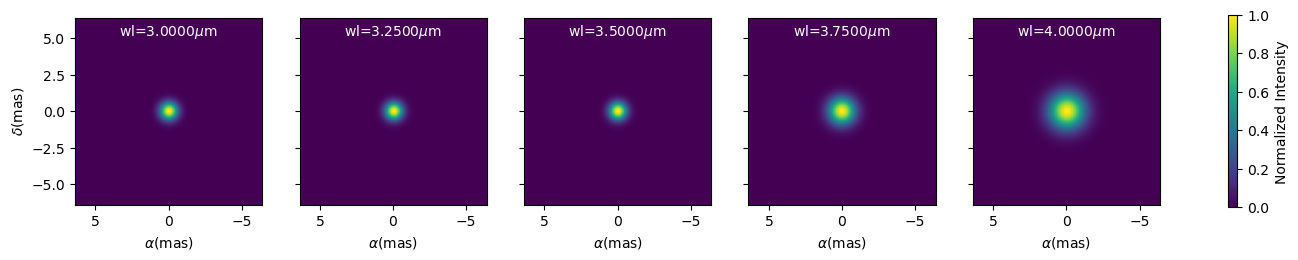

In [9]:
wls=np.linspace(3e-6,4e-6,num=5)
fig, ax, im = mg.showModel(128,0.1,wl=wls,normalize=True,normPow=1,legend=True)

### The interpolated values of the parameter can be accessed directly with the call operator:

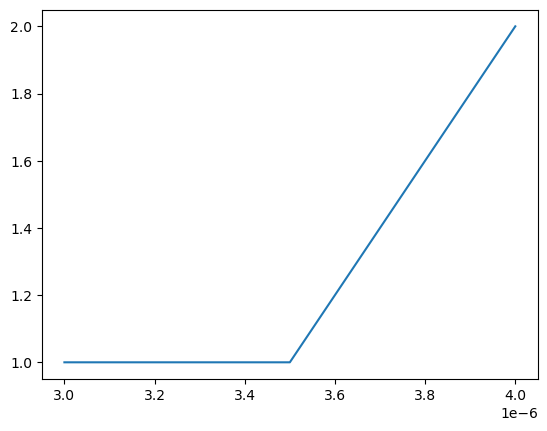

In [10]:
fwhm = g.params["fwhm"](wl=wls)
fig,ax = plt.subplots()
ax.plot(wls,fwhm)

Now that you know the basics of oimodeler interpolators let’s apply this to our MATISSE data on
HD179218.

### Chromatic interpolation in the case of HD179218

Here is the code to create our simple yet chromatic model for HD179218:

In [12]:
pt2 = oim.oimPt()
g2 = oim.oimGauss(f=oim.oimInterp("wl", wl=[3e-6, 4e-6], values=[1,2]))
m2 = oim.oimModel(g2, pt2)
g2.params["fwhm"].set( max = 100 )
pt2.params["f"] = oim.oimParamNorm(g2.params["f"])

#### **Question : Here, which parameter is made chromatic?**

#### **Question : What is the physical reason for such chromaticity?**

### Running the mcmc fitter on this new chromatic model

In [13]:
fit=oim.oimFitterEmcee(data, m2,nwalkers=10,dataTypes=["VISAMP"])
fit.prepare()
fit.run(nsteps=1000,progress=True)

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 99.71it/s]


{'nsteps': 1000, 'progress': True}

### Printing and plotting the results

c1_GD_f_interp1 = 0.84247 ± 0.00061 
c1_GD_f_interp2 = 0.91125 ± 0.00057 
c1_GD_fwhm = 57.35142 ± 0.15965 mas
chi2r = 13.35911


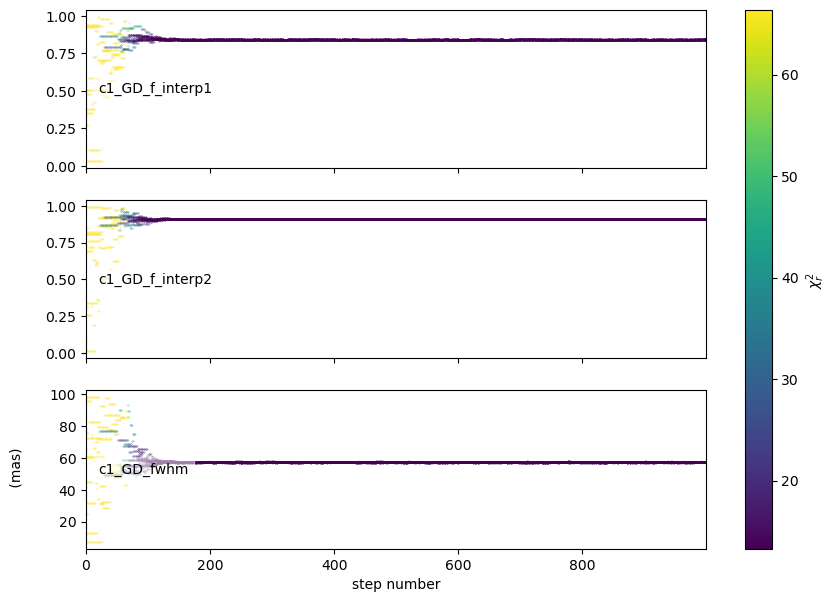

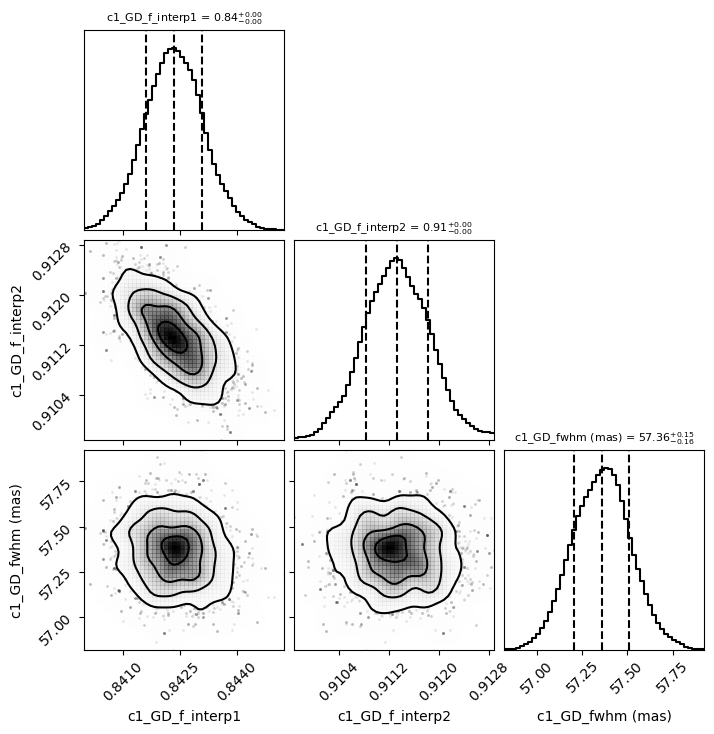

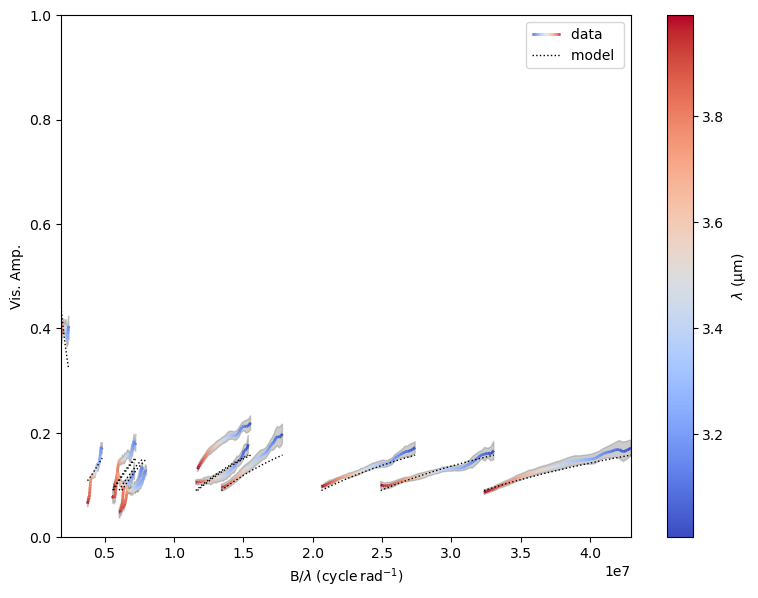

In [14]:
fit.printResults(mode='best', discard=500)
figWalker,axWalker = fit.walkersPlot(chi2limfact=5)
figCorner,axCorner = fit.cornerPlot(discard=500,chi2limfact=5)
figSim,axSim = fit.simulator.plot(["VISAMP"])

#### **Question : Is the visibility better fitted?**